In [1]:
!wget https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip

--2024-05-29 14:19:51--  https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c5:2ef4, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105946856 (101M) [application/zip]
Saving to: ‘fruits.zip’

fruits.zip          100%[===================>] 101.04M  57.9MB/s    in 1.7s    

2024-05-29 14:19:55 (57.9 MB/s) - ‘fruits.zip’ saved [105946856/105946856]



In [2]:
!unzip fruits.zip

Archive:  fruits.zip
   creating: fruits/
  inflating: __MACOSX/._fruits       
  inflating: fruits/.DS_Store        
  inflating: __MACOSX/fruits/._.DS_Store  
   creating: fruits/test/
   creating: fruits/train/
   creating: fruits/validation/
   creating: fruits/test/apple/
  inflating: fruits/test/.DS_Store   
  inflating: __MACOSX/fruits/test/._.DS_Store  
   creating: fruits/test/banana/
   creating: fruits/test/orange/
   creating: fruits/train/apple/
  inflating: fruits/train/.DS_Store  
  inflating: __MACOSX/fruits/train/._.DS_Store  
   creating: fruits/train/banana/
   creating: fruits/train/orange/
   creating: fruits/validation/apple/
  inflating: fruits/validation/.DS_Store  
  inflating: __MACOSX/fruits/validation/._.DS_Store  
   creating: fruits/validation/banana/
   creating: fruits/validation/orange/
  inflating: fruits/test/apple/Screen Shot 2018-06-08 at 5.27.19 PM.png  
  inflating: __MACOSX/fruits/test/apple/._Screen Shot 2018-06-08 at 5.27.19 PM.png  
  inflatin

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
img_height, img_width = 32, 32
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 460 files belonging to 3 classes.
Found 66 files belonging to 3 classes.
Found 130 files belonging to 3 classes.


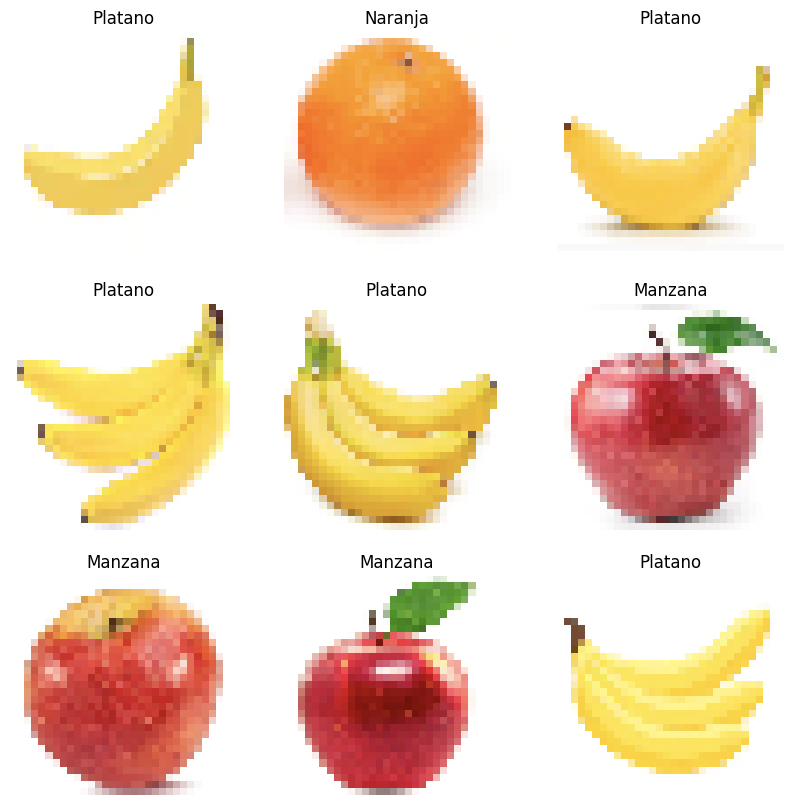

In [5]:
class_names = ["Manzana", "Platano", "Naranja"]
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(3)
    ]
)


In [7]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

In [8]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10
)

Epoch 1/10
23/23 [==============================] - 6s 79ms/step - loss: 0.9496 - accuracy: 0.5565 - val_loss: 0.6901 - val_accuracy: 0.8333
Epoch 2/10
23/23 [==============================] - 3s 79ms/step - loss: 0.5723 - accuracy: 0.7826 - val_loss: 0.5779 - val_accuracy: 0.7273
Epoch 3/10
23/23 [==============================] - 2s 50ms/step - loss: 0.4020 - accuracy: 0.8674 - val_loss: 0.3020 - val_accuracy: 0.8939
Epoch 4/10
23/23 [==============================] - 2s 53ms/step - loss: 0.3161 - accuracy: 0.8891 - val_loss: 0.2695 - val_accuracy: 0.9242
Epoch 5/10
23/23 [==============================] - 2s 50ms/step - loss: 0.2618 - accuracy: 0.9022 - val_loss: 0.2099 - val_accuracy: 0.9242
Epoch 6/10
23/23 [==============================] - 2s 50ms/step - loss: 0.3605 - accuracy: 0.8565 - val_loss: 0.3277 - val_accuracy: 0.8636
Epoch 7/10
23/23 [==============================] - 2s 51ms/step - loss: 0.2171 - accuracy: 0.9370 - val_loss: 0.2578 - val_accuracy: 0.9242
Epoch 8/10
23

In [9]:
model.evaluate(test_ds)

7/7 [==============================] - 1s 28ms/step - loss: 0.3128 - accuracy: 0.9154


[0.31283190846443176, 0.9153845906257629]

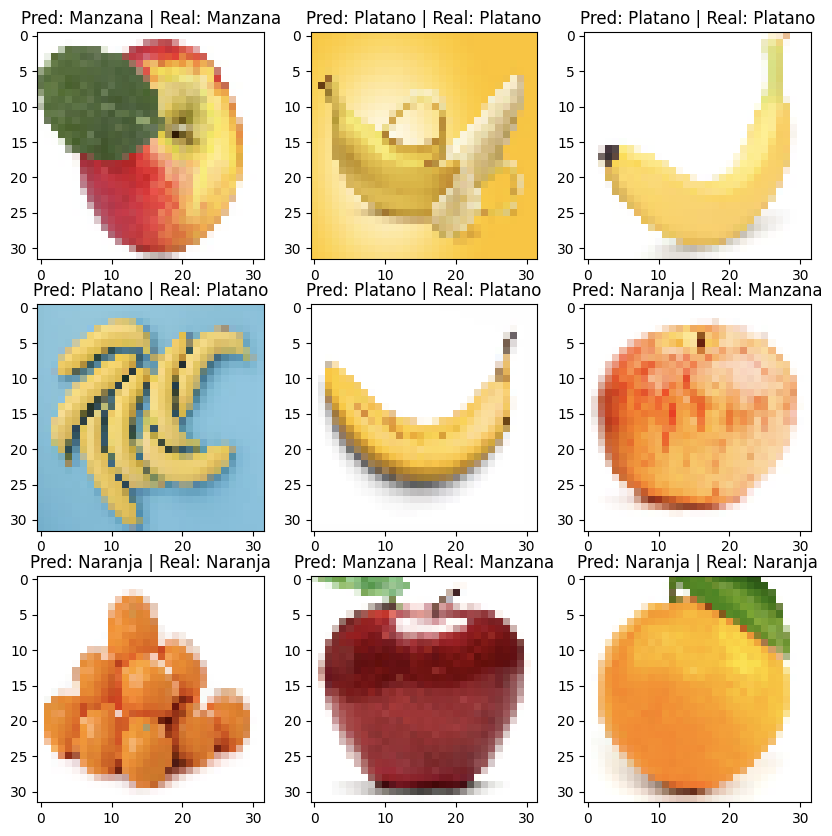

In [10]:
import numpy

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  # print(classifications)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

In [12]:
import pickle

# Guardar el modelo en formato pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
